In [1]:
from numpy.random import seed
seed(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from analysis import *
from collections import namedtuple
import Metrics
from PatientSet import PatientSet
from Constants import Constants
from Clustering import *
import re

#sklearn dependencies
from sklearn.metrics import roc_auc_score, adjusted_rand_score
from sklearn.utils import resample
from sklearn.cluster import FeatureAgglomeration

#we get like a million deprication errors for some reason with the external libraries
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

W1002 19:34:59.407218  1360 deprecation_wrapper.py:119] From F:\Skool\EVL_Research\CAMP-RT\PYTHON\PatientSet.py:8: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

Using TensorFlow backend.
F:\Anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
#plotting parameter
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
FIG_SIZE = (20,15)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=FIG_SIZE)

In [3]:
#load in the patientset object that has all the patient info
db = PatientSet()

#add a bunch of features to the object that we'll want to try
#so we can use the db.to_dataframe function to get them all in a nice dataframe with one-hot encoding and labels automatically
db.t_volumes = np.array([np.sum([g.volume for g in gtvs]) for gtvs in db.gtvs]).reshape(-1,1)
db.bilateral = db.lateralities == 'B'
db.total_volumes = db.volumes.sum(axis = 1)
db.toxicity = db.feeding_tubes + db.aspiration > 0
db.tsimdoses = tsim_prediction(db)
db.neck_width = np.linalg.norm(db.centroids[:,Constants.organ_list.index('Lt_Sternocleidomastoid_M'),:] - db.centroids[:,Constants.organ_list.index('Rt_Sternocleidomastoid_M'), :], axis = 1)

F:\Skool\EVL_Research\CAMP-RT\PYTHON\Patient.py:360: RuntimeWarning: invalid value encountered in true_divide
  mean_tumor_distances /= tumor_volume
F:\Skool\EVL_Research\CAMP-RT\PYTHON\Patient.py:361: RuntimeWarning: invalid value encountered in true_divide
  tumor_position /= tumor_volume


error reading tumor volume for  10041
error reading tumor volume for  10091
error reading tumor volume for  10148


W1002 19:35:29.806957  1360 deprecation_wrapper.py:119] From F:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1002 19:35:29.807957  1360 deprecation_wrapper.py:119] From F:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1002 19:35:29.811957  1360 deprecation_wrapper.py:119] From F:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1002 19:35:29.819957  1360 deprecation_wrapper.py:119] From F:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1002 19:35:29.912963  1360 deprecation_wrapper.py:119] From F:\Anaconda\lib\site-packages\keras\opt


patient data loaded...



In [162]:
%load_ext autoreload
%autoreload 2
from Clustering import *

#parameters for the experiments
toxicities_to_test = ['toxicity']

#features to test the feature selection on.  should be fields in the patientset we have
#we don't cluster on these
unclusterable_features = ['t_volumes', 'bilateral', 'total_volumes','neck_width']
#we cluster on these (each individually) if feature_clustering is defined,
clusterable_features = ['tumor_distances', 'volumes']

#features specifically for feature selection vs actually using.  Should either be
#some combo of actual and predicted dose for this
true_features = ['doses']
predicted_features = ['tsimdoses']

#number of times to resample and doing feature selection
#if n = 1, just use the first result
n_samples = 1

rescale = False
df_rescale = Metrics.normalize

#put some bounds on the features to subset
min_features = 2

#for now just constrain it to one cluster
n_clusters = 2
selection_clusterer  = FClusterer(n_clusters)
cluster_feature_selector = FeatureClusterSelector(
    n_samples = n_samples,
    clusterer = selection_clusterer)
lg_feature_selector = FeatureSelector(n_samples = n_samples)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
true, predicted = get_train_test_datasets(db, 
                                      unclusterable_features, 
                                      clusterable_features, 
                                      true_features, 
                                      predicted_features)

In [164]:
cluster_importances = cluster_feature_selector.get_importances(predicted, db.toxicity, as_df = True)
cluster_importances.describe()

,Esophagus_tsimdoses,Spinal_Cord_tsimdoses,Cricopharyngeal_Muscle_tsimdoses,Cricoid_cartilage_tsimdoses,IPC_tsimdoses,MPC_tsimdoses,Brainstem_tsimdoses,Larynx_tsimdoses,Thyroid_cartilage_tsimdoses,Supraglottic_Larynx_tsimdoses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,1.0,1.0,1.000000,1.00,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.00,1.00000,1.000000,1.0,1.000000,1.000000,1.0
mean,0.0,0.0,0.996069,0.83,0.999433,1.0,0.999844,0.997188,0.991769,0.999939,...,0.67078,0.785873,0.948318,0.83,0.86577,0.991312,0.0,0.973297,0.688191,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.996069,0.83,0.999433,1.0,0.999844,0.997188,0.991769,0.999939,...,0.67078,0.785873,0.948318,0.83,0.86577,0.991312,0.0,0.973297,0.688191,0.0
25%,0.0,0.0,0.996069,0.83,0.999433,1.0,0.999844,0.997188,0.991769,0.999939,...,0.67078,0.785873,0.948318,0.83,0.86577,0.991312,0.0,0.973297,0.688191,0.0
50%,0.0,0.0,0.996069,0.83,0.999433,1.0,0.999844,0.997188,0.991769,0.999939,...,0.67078,0.785873,0.948318,0.83,0.86577,0.991312,0.0,0.973297,0.688191,0.0
75%,0.0,0.0,0.996069,0.83,0.999433,1.0,0.999844,0.997188,0.991769,0.999939,...,0.67078,0.785873,0.948318,0.83,0.86577,0.991312,0.0,0.973297,0.688191,0.0
max,0.0,0.0,0.996069,0.83,0.999433,1.0,0.999844,0.997188,0.991769,0.999939,...,0.67078,0.785873,0.948318,0.83,0.86577,0.991312,0.0,0.973297,0.688191,0.0


In [165]:
lg_importances = lg_feature_selector.get_importances(predicted, db.toxicity, as_df = True)
lg_importances.describe()

,Esophagus_tsimdoses,Spinal_Cord_tsimdoses,Cricopharyngeal_Muscle_tsimdoses,Cricoid_cartilage_tsimdoses,IPC_tsimdoses,MPC_tsimdoses,Brainstem_tsimdoses,Larynx_tsimdoses,Thyroid_cartilage_tsimdoses,Supraglottic_Larynx_tsimdoses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.602941,0.713678,0.699504,0.70287,0.682849,0.727321,0.639086,0.693125,0.685684,0.698972,...,0.536145,0.476258,0.637845,0.169561,0.571403,0.617647,0.557938,0.670092,0.127392,0.631821
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.602941,0.713678,0.699504,0.70287,0.682849,0.727321,0.639086,0.693125,0.685684,0.698972,...,0.536145,0.476258,0.637845,0.169561,0.571403,0.617647,0.557938,0.670092,0.127392,0.631821
25%,0.602941,0.713678,0.699504,0.70287,0.682849,0.727321,0.639086,0.693125,0.685684,0.698972,...,0.536145,0.476258,0.637845,0.169561,0.571403,0.617647,0.557938,0.670092,0.127392,0.631821
50%,0.602941,0.713678,0.699504,0.70287,0.682849,0.727321,0.639086,0.693125,0.685684,0.698972,...,0.536145,0.476258,0.637845,0.169561,0.571403,0.617647,0.557938,0.670092,0.127392,0.631821
75%,0.602941,0.713678,0.699504,0.70287,0.682849,0.727321,0.639086,0.693125,0.685684,0.698972,...,0.536145,0.476258,0.637845,0.169561,0.571403,0.617647,0.557938,0.670092,0.127392,0.631821
max,0.602941,0.713678,0.699504,0.70287,0.682849,0.727321,0.639086,0.693125,0.685684,0.698972,...,0.536145,0.476258,0.637845,0.169561,0.571403,0.617647,0.557938,0.670092,0.127392,0.631821


In [181]:

top_n_importances = lambda x, n: x.mean().sort_values(ascending = False).iloc[0:n]
def plot_n_importances(x, n):
    x = x.reindex(x.mean().sort_values(ascending=False).index, axis = 'columns')
    x = x.iloc[:,0:n]
    xrange = [x.mean().values.min()*.99, x.mean().values.max()*1.01]
    x.mean().plot.barh(**{'xerr': x.std().values/np.sqrt(n_samples), 'xlim': xrange})

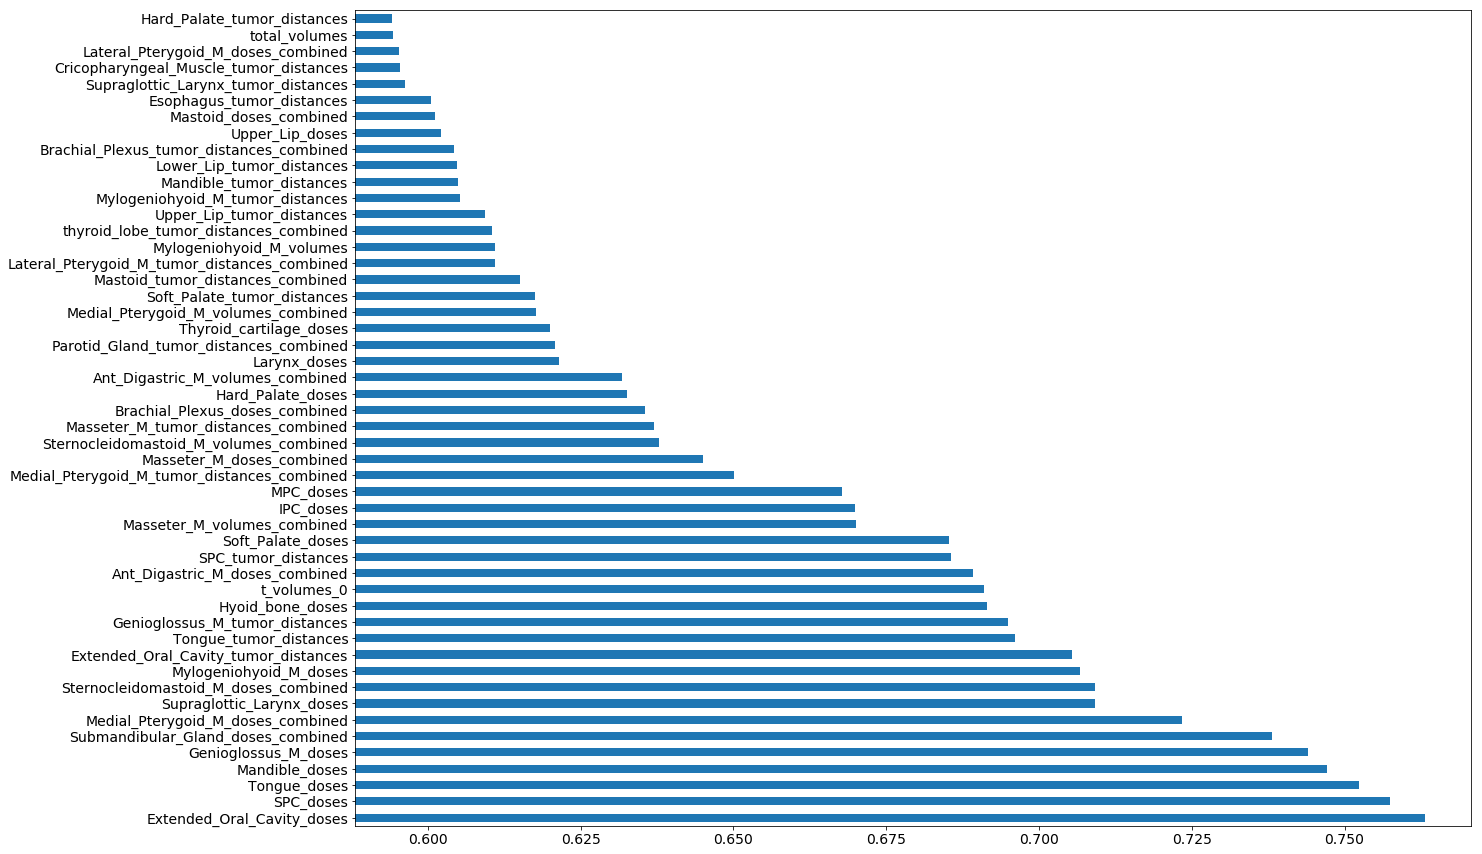

In [190]:
plot_n_importances(cluster_importances, 50)

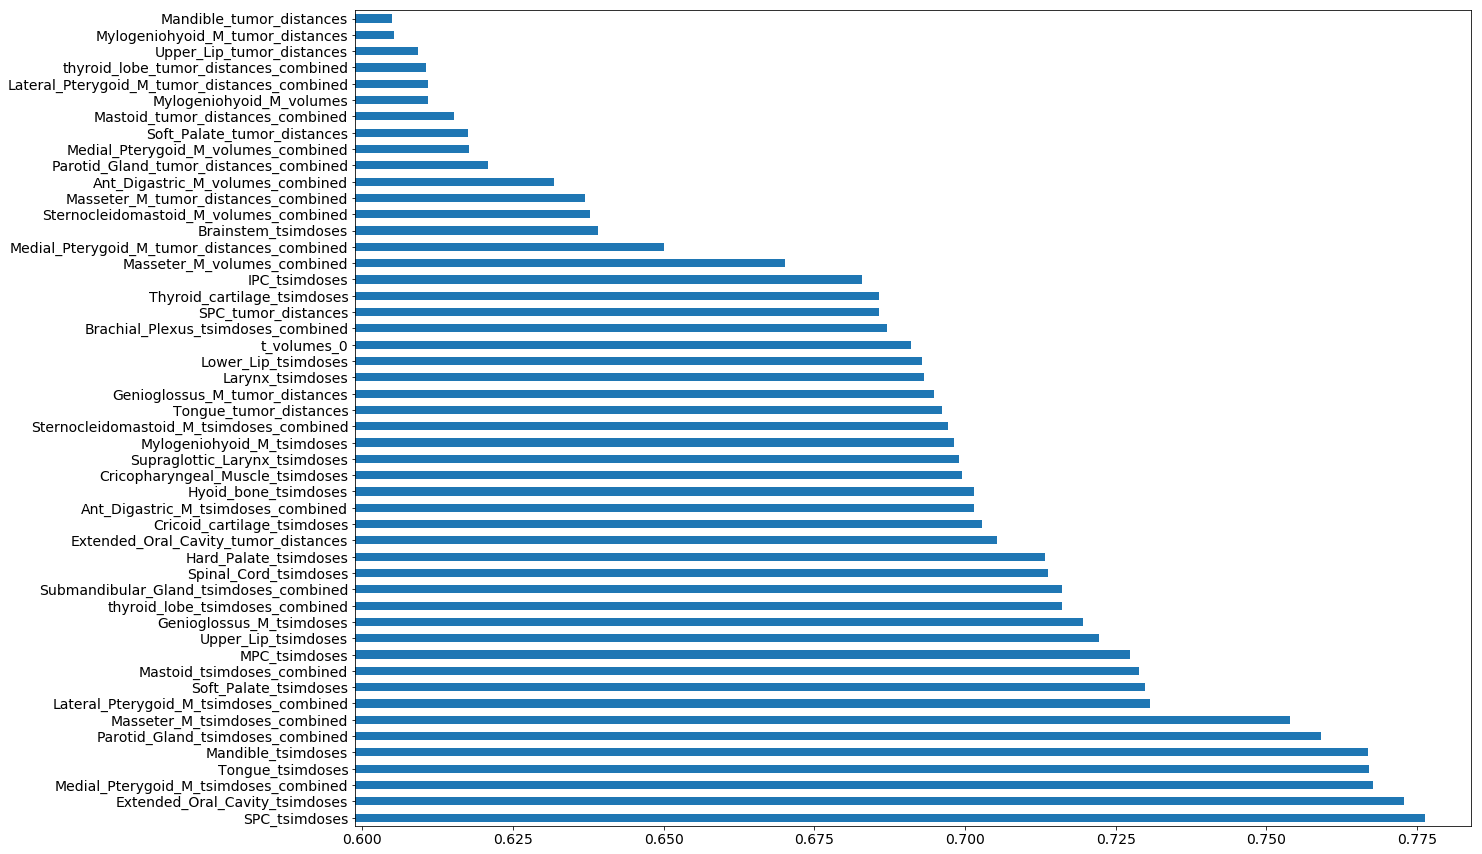

In [188]:
plot_n_importances(lg_importances,50)

In [169]:
true_cluster_importances = cluster_importances = cluster_feature_selector.get_importances(true, db.toxicity, as_df = True)
true_cluster_importances.describe()

,Esophagus_doses,Spinal_Cord_doses,Cricopharyngeal_Muscle_doses,Cricoid_cartilage_doses,IPC_doses,MPC_doses,Brainstem_doses,Larynx_doses,Thyroid_cartilage_doses,Supraglottic_Larynx_doses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.00,1.00000,1.000000,1.0,1.000000,1.000000,1.0
mean,0.617074,0.183377,0.985731,0.991769,0.995796,0.997707,0.991312,0.997086,0.993115,0.999977,...,0.67078,0.785873,0.948318,0.83,0.86577,0.991312,0.0,0.973297,0.688191,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.617074,0.183377,0.985731,0.991769,0.995796,0.997707,0.991312,0.997086,0.993115,0.999977,...,0.67078,0.785873,0.948318,0.83,0.86577,0.991312,0.0,0.973297,0.688191,0.0
25%,0.617074,0.183377,0.985731,0.991769,0.995796,0.997707,0.991312,0.997086,0.993115,0.999977,...,0.67078,0.785873,0.948318,0.83,0.86577,0.991312,0.0,0.973297,0.688191,0.0
50%,0.617074,0.183377,0.985731,0.991769,0.995796,0.997707,0.991312,0.997086,0.993115,0.999977,...,0.67078,0.785873,0.948318,0.83,0.86577,0.991312,0.0,0.973297,0.688191,0.0
75%,0.617074,0.183377,0.985731,0.991769,0.995796,0.997707,0.991312,0.997086,0.993115,0.999977,...,0.67078,0.785873,0.948318,0.83,0.86577,0.991312,0.0,0.973297,0.688191,0.0
max,0.617074,0.183377,0.985731,0.991769,0.995796,0.997707,0.991312,0.997086,0.993115,0.999977,...,0.67078,0.785873,0.948318,0.83,0.86577,0.991312,0.0,0.973297,0.688191,0.0


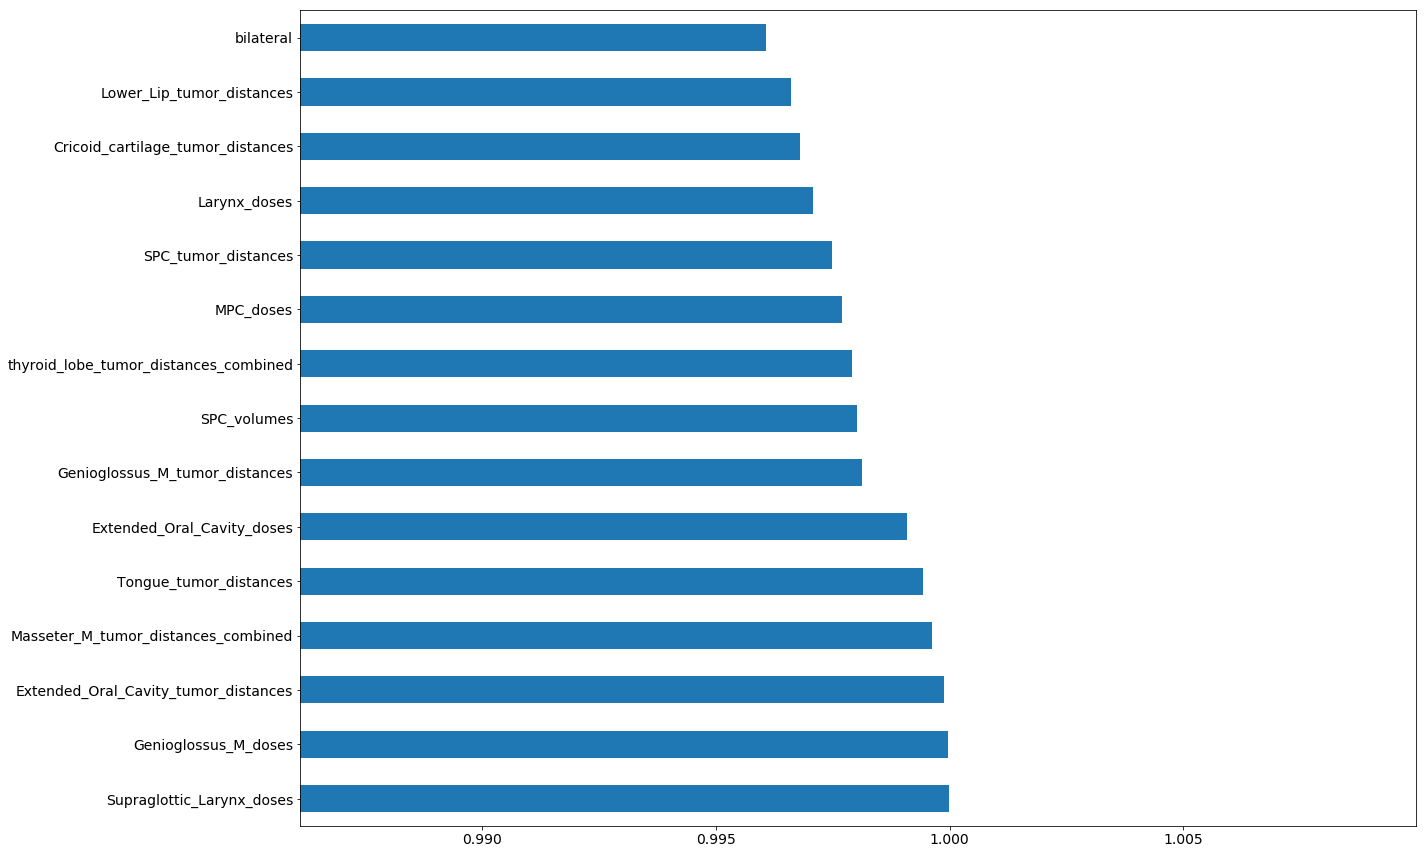

In [184]:
plot_n_importances(true_cluster_importances, 15)

In [171]:
true_lg_importances = cluster_importances = lg_feature_selector.get_importances(true, db.toxicity, as_df = True)
true_lg_importances.describe()

,Esophagus_doses,Spinal_Cord_doses,Cricopharyngeal_Muscle_doses,Cricoid_cartilage_doses,IPC_doses,MPC_doses,Brainstem_doses,Larynx_doses,Thyroid_cartilage_doses,Supraglottic_Larynx_doses,...,Brachial_Plexus_volumes_combined,thyroid_lobe_volumes_combined,Sternocleidomastoid_M_volumes_combined,Mastoid_volumes_combined,Parotid_Gland_volumes_combined,Medial_Pterygoid_M_volumes_combined,Lateral_Pterygoid_M_volumes_combined,Masseter_M_volumes_combined,Submandibular_Gland_volumes_combined,Ant_Digastric_M_volumes_combined
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.524982,0.445074,0.524096,0.516832,0.669915,0.667789,0.552091,0.621545,0.61995,0.709249,...,0.536145,0.476258,0.637845,0.169561,0.571403,0.617647,0.557938,0.670092,0.127392,0.631821
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.524982,0.445074,0.524096,0.516832,0.669915,0.667789,0.552091,0.621545,0.61995,0.709249,...,0.536145,0.476258,0.637845,0.169561,0.571403,0.617647,0.557938,0.670092,0.127392,0.631821
25%,0.524982,0.445074,0.524096,0.516832,0.669915,0.667789,0.552091,0.621545,0.61995,0.709249,...,0.536145,0.476258,0.637845,0.169561,0.571403,0.617647,0.557938,0.670092,0.127392,0.631821
50%,0.524982,0.445074,0.524096,0.516832,0.669915,0.667789,0.552091,0.621545,0.61995,0.709249,...,0.536145,0.476258,0.637845,0.169561,0.571403,0.617647,0.557938,0.670092,0.127392,0.631821
75%,0.524982,0.445074,0.524096,0.516832,0.669915,0.667789,0.552091,0.621545,0.61995,0.709249,...,0.536145,0.476258,0.637845,0.169561,0.571403,0.617647,0.557938,0.670092,0.127392,0.631821
max,0.524982,0.445074,0.524096,0.516832,0.669915,0.667789,0.552091,0.621545,0.61995,0.709249,...,0.536145,0.476258,0.637845,0.169561,0.571403,0.617647,0.557938,0.670092,0.127392,0.631821


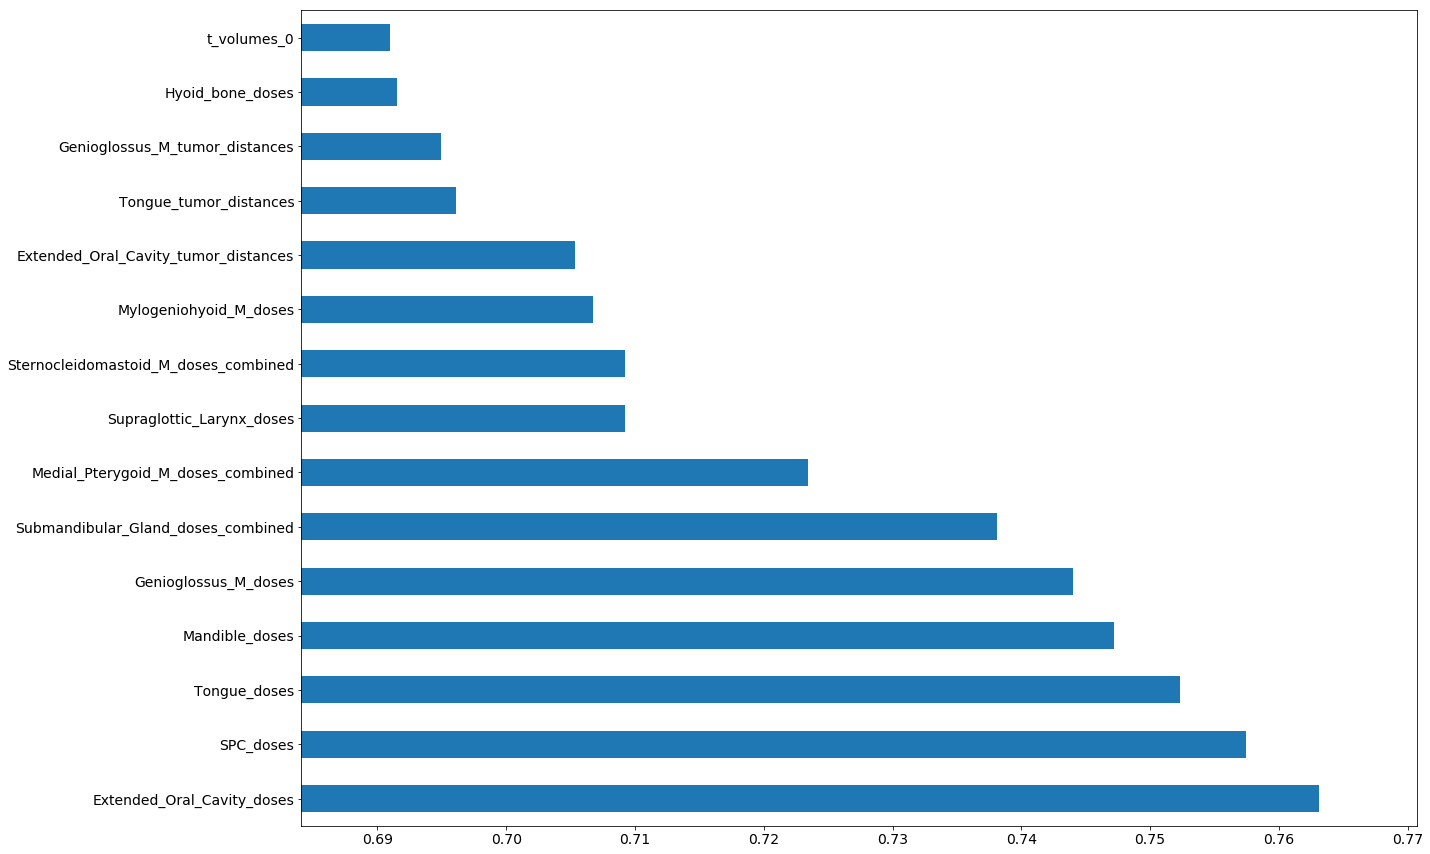

In [185]:
plot_n_importances(true_lg_importances, 15)

In [173]:
selected_features = pd.read_csv('data/clustering_results/metaClusteringBootstrapped2.csv',index_col=0)
cluster_labels = selected_features.cluster_labels
selected_features = selected_features.drop('cluster_labels', axis = 1)
selected_features.head(5)

,Extended_Oral_Cavity_tsimdoses,Mandible_tumor_distances,Masseter_M_tsimdoses_combined
Dummy.ID,,,
3,-0.551148,1.219089,0.089514
4,-0.867771,0.128503,-1.046533
10,-0.048441,0.447453,-0.303776
11,-1.087914,-1.149189,-1.437417
27,-0.913117,-1.149189,-1.116530


In [174]:
scorer = FeatureClusterSelector(clusterer = copy(selection_clusterer))
scores = {f: [] for f in selected_features.columns}
scores['baseline'] = []
for n in range(n_samples):
    if n_samples > 1:
        xtemp, ytemp = resample(selected_features, db.toxicity)
    else:
        xtemp, ytemp = selected_features, db.toxicity
    base_score = scorer.bootstrap_score(xtemp, ytemp).mean()
    scores['baseline'].append(base_score)
    for feature in  selected_features.columns:
        xtemp = selected_features.drop(feature, axis = 1)
        new_score = scorer.bootstrap_score(xtemp, db.toxicity).mean()
        scores[feature].append(base_score-new_score)
scores = pd.DataFrame(scores)
scores.describe()

,Extended_Oral_Cavity_tsimdoses,Mandible_tumor_distances,Masseter_M_tsimdoses_combined,baseline
count,1.000000,1.000000e+00,1.000000e+00,1.0
mean,0.000429,4.570105e-09,7.516935e-10,1.0
std,NaN,NaN,NaN,NaN
min,0.000429,4.570105e-09,7.516935e-10,1.0
25%,0.000429,4.570105e-09,7.516935e-10,1.0
50%,0.000429,4.570105e-09,7.516935e-10,1.0
75%,0.000429,4.570105e-09,7.516935e-10,1.0
max,0.000429,4.570105e-09,7.516935e-10,1.0


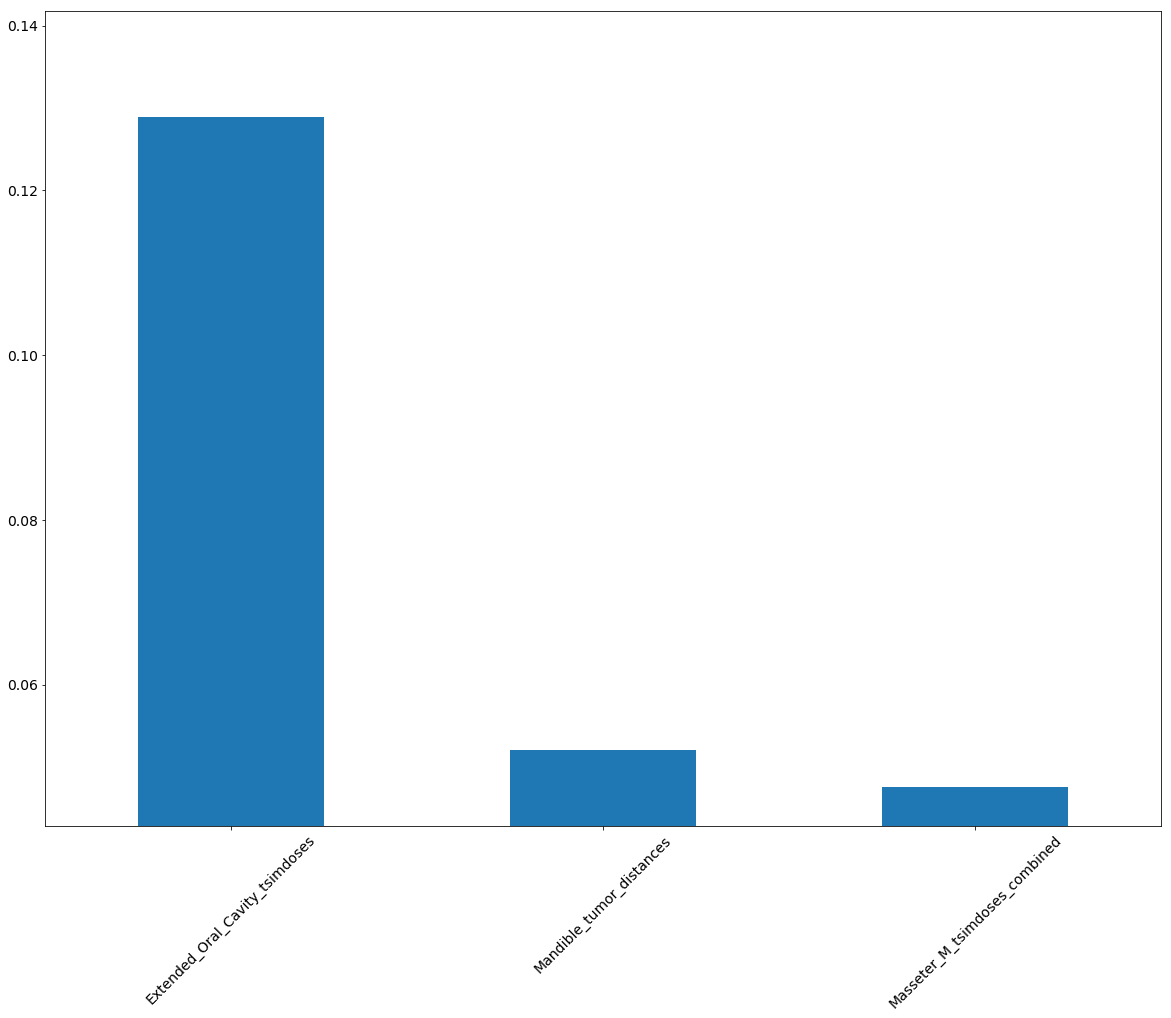

In [175]:
fscores = scores.drop('baseline', axis = 1).apply(lambda x: 1/np.log(np.abs(1/x))*np.sign(x))
yerr = fscores.std()/np.sqrt(n_samples) if n_samples > 1 else np.zeros((fscores.shape[1],))
yrange = [fscores.mean().values.min()*.9, fscores.mean().values.max()*1.1]
(fscores.mean()).plot.bar(rot = 45, **{'ylim': yrange,'yerr': yerr})

In [189]:
cluster_importances.Hyoid_bone_doses

0    0.691531
Name: Hyoid_bone_doses, dtype: float64